# Background Stuff
Explain what we are doing here

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import describe
import re
from collections import Counter

from src.utils import prep_data, train_and_evaluate_model, get_x_y

SEED = 2018

Using TensorFlow backend.


In [2]:
x_train_raw, y_train_raw = get_x_y('data/train')

In [3]:
review_lengths = []
for review in x_train_raw:
    review_lengths.append(len(review.split(' ')))

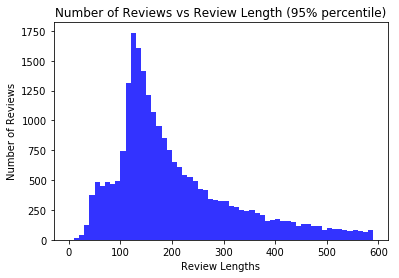

In [4]:
percent_95 = np.percentile(review_lengths, 95)
bins = np.arange(0, percent_95, 10)
plt.hist(review_lengths,bins,color='blue',alpha=0.8)
plt.xlabel('Review Lengths')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews vs Review Length (95% percentile)')
plt.show()

In [5]:
words = []

for review in x_train_raw:
    # Removes puncuation
    review = re.sub(r'[^\w\s]','',review)
    for word in review.split(' '):
        words.append(word)

In [6]:
counter = Counter(words)
values = list(counter.values())

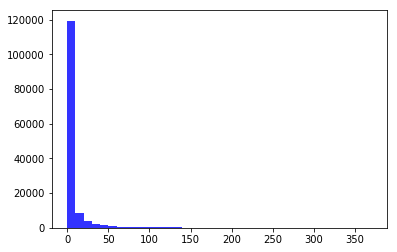

In [7]:
percent_95 = np.percentile(values, 99)
bins = np.arange(0, percent_95, 10)
plt.hist(values,bins,color='blue',alpha=0.8)
plt.show()

In [ ]:
max_review_lengths = [10, 50, 100, 200, 300, 400, 500]
vocab_sizes = [100, 250, 500]
scores = {}
counter = 1
num_trials = len(max_review_lengths) * len(vocab_sizes)

for vocab_size in vocab_sizes:
    scores[vocab_size] = []
    for max_review in max_review_lengths:
        print('Running trial ' + str(counter) + ' of ' + str(num_trials))
        x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub = prep_data(
            vocab_size=vocab_size,
            max_review_len=max_review
        )

        scores[vocab_size].append(
            train_and_evaluate_model(
                x_train=x_train_pad_sub,
                y_train=y_train_sub,
                x_test=x_test_pad_sub,
                y_test=y_test_sub,
                num_epochs=2,
                max_review_len=max_review,
                verbose=0
            )
        )

        counter += 1

Running trial 1 of 21
5000/5000 [==============================] - 1s 226us/step
Running trial 2 of 21
5000/5000 [==============================] - 3s 608us/step
Running trial 3 of 21
5000/5000 [==============================] - 5s 1ms/step
Running trial 4 of 21
5000/5000 [==============================] - 9s 2ms/step
Running trial 5 of 21


In [ ]:
fig = plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
x_range = np.arange(len(next(iter(scores.values()))))
width = 0.25
legend_values = []

for counter, vocab_size in enumerate(scores):
    plt.bar(x_range + width*(counter - 1), scores[vocab_size], width)
    legend_values.append('Vocab Size ' + str(vocab_size))
    
plt.xticks(x_range, max_review_lengths)
plt.ylim([0, 100])
plt.xlabel('Max Review Lengths')
plt.ylabel('Accuracy %')
plt.title('Length of Reviews vs Accuracy (5k Samples Used)')
plt.legend(legend_values)

plt.show()